# Entrenar el modelo de default

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('default_ABT2.csv')

In [4]:
#relleno los nulos con 0, ya que los algoritmos no toleran valores nulos
df = df.fillna(0)

In [28]:
# entreno con los primeros meses hasta octubre incluido, testeo con nov-dic y enero
tr = df[df['DATE']< '2023-11-01']
te = df[df['DATE']> '2023-10-31']
resultado = df[df['DATE']> '2023-10-31'] #filtrar por fecha que se va a estar prediciendo (debe ser la misma que en te)

In [29]:
# exclusivo test 1 mes Noviembre
te = te[te['DATE']< '2023-12-01']
resultado = resultado[resultado['DATE']< '2023-12-01']

In [30]:
# me quedo sólo con las variables numéricas que pueden ser leídas por el modelo
tr= tr.select_dtypes(['number'])
te = te.select_dtypes(['number'])

In [31]:
#separar en train y test
X_train = tr.drop(["TARGET"], axis=1)
y_train = tr.TARGET
X_test = te.drop(["TARGET"], axis=1)
y_test = te.TARGET

In [32]:
#standarizo las variables para que no haya efecto de numéricas grandes vs conteos
sttr=  StandardScaler().fit_transform(X_train)
stte=  StandardScaler().fit_transform(X_test)

In [33]:
X_train= pd.DataFrame(data = sttr, columns = X_train.columns, index = X_train.index)
X_test  = pd.DataFrame(data = stte, columns = X_test.columns, index = X_test.index)

# Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)

0.9990165733465072

In [17]:
clf.score(X_test, y_test)

0.998899816882273

# guardar el modelo
from pickle import dump
with open("Logistic_reg_default.pkl", "wb") as f:
    dump(clf, f, protocol=5)

# Para realizar predicciones

In [36]:
# me quedo con fecha y id_branch para los resultados
lista = ['DATE','ID_BRANCH', 'AGENCY', 'ID_GROUP_COMPANY', 'BALANCE', 'DEFAULT', 'TARGET']
resultado = resultado[lista]

In [59]:
#obtengo la probabilidad calculada por el modelo para cada agencia para cada fecha
X_test['proba'] = clf.predict_proba(X_test)[:, 1]

In [60]:
#separo en deciles para ver cuan viene ordena los datos
percentiles = pd.qcut(X_test['proba'], 10, labels=False, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
X_test['deciles'] = percentiles
X_test['deciles'] = X_test['deciles'].astype('Int32')


In [61]:
Aux = pd.merge(X_test, y_test, left_index=True,right_index=True, how='left')

In [62]:
pd.crosstab(Aux['deciles'],Aux['TARGET'])

TARGET,0.0,1.0
deciles,,
1,21279,105
2,20846,21
3,21845,35
4,21397,8
5,21371,13
6,21373,11
7,21371,13
8,21382,2
9,21383,1


In [63]:
# obtener los valores de probabilidad mínimo para cada decil
min_proba_per_decile = X_test.groupby('deciles')['proba'].min()

In [64]:
min_proba_per_decile

deciles
1     1.092983e-03
2     1.059784e-03
3     1.019937e-03
4     9.566535e-04
5     8.494559e-04
6     6.925173e-04
7     5.149708e-04
8     2.925885e-04
9     7.535967e-05
10    4.040109e-28
Name: proba, dtype: float64

# Defaults evitados en 1 mes, dinero recuperado

In [38]:
#obtengo la prediccción calculada por el modelo para cada agencia para cada fecha
resultado['proba'] = clf.predict_proba(X_test)[:, 1]
#resultado['predict'] = clf.predict(X_test)

In [39]:
 clf.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
print (resultado.shape)
print (X_test.shape)

(213840, 9)
(213840, 99)


In [41]:
resultado[resultado['predict'] == 1]

,DATE,ID_BRANCH,AGENCY,ID_GROUP_COMPANY,BALANCE,DEFAULT,TARGET,proba,predict


In [42]:
target = resultado[resultado['TARGET'] == 1]

,DATE,ID_BRANCH,AGENCY,ID_GROUP_COMPANY,BALANCE,DEFAULT,TARGET,proba,predict
188243,2023-11-11,A10362,MN0147,USA010483,0.0000,0.0,1.0,0.000951,0.0
192636,2023-11-15,A10537,0,0,0.0000,0.0,1.0,0.001060,0.0
241716,2023-11-18,A12153,0,0,10746.0901,0.0,1.0,0.001126,0.0
327510,2023-11-27,A14223,OH0069,USA013011,3022.0731,0.0,1.0,0.000546,0.0
338262,2023-11-06,A14375,NC1093,USA013103,9644.0236,0.0,1.0,0.000480,0.0
...,...,...,...,...,...,...,...,...,...
2673216,2023-11-12,A25687,CA4643,USA020988,0.0000,0.0,1.0,0.001060,0.0
2676019,2023-11-22,A25695,OK0244,USA020992,0.0000,0.0,1.0,0.001059,0.0
2679615,2023-11-27,A25704,OK0245,USA020999,0.0000,0.0,1.0,0.001060,0.0
2684396,2023-11-20,A25719,CO0385,USA015950,160.0000,0.0,1.0,0.001063,0.0


In [43]:
platadia0 = resultado[resultado['DEFAULT'] == 1]

In [44]:
platadia0['BALANCE'].sum()

971345.7361

In [51]:
# Assuming df is your DataFrame and 'defaults' is the column where defaults occur
resultado['default_next_day'] = resultado['DEFAULT'].shift(-1)

# Now, df['default_next_day'] will be True for the rows just before a default occurs
df_before_defaults = resultado[resultado['default_next_day'] == 1]


In [48]:
df_before_defaults['BALANCE'].sum()

1574015.0507

In [ ]:
# dinero que puede ser cobrado a tiempo
1574015

In [50]:
# filtrando con probabilidad que captura aprox 60% de los defaults 0.00108
resultado['proba2'] = resultado['proba'].shift(8)#8 días adelnte lo muevo porque veo el balance el día anterior

In [65]:
predicho = df_before_defaults[df_before_defaults['proba2'] >1.092983e-03]

In [66]:
predicho['BALANCE'].sum()

703156.0516

In [67]:
predicho = df_before_defaults[df_before_defaults['proba2'] >1.059784e-03]
predicho['BALANCE'].sum()

739275.9777

In [68]:
predicho = df_before_defaults[df_before_defaults['proba2'] >1.019937e-03]
predicho['BALANCE'].sum()

783006.4677

In [69]:
predicho = df_before_defaults[df_before_defaults['proba2'] >9.566535e-04]
predicho['BALANCE'].sum()

899579.618

In [70]:
predicho = df_before_defaults[df_before_defaults['proba2'] >8.494559e-04]
predicho['BALANCE'].sum()

1045465.0659999999

In [71]:
resultado.head()

,DATE,ID_BRANCH,AGENCY,ID_GROUP_COMPANY,BALANCE,DEFAULT,TARGET,proba,predict,default_next_day,proba2
304,2023-11-01,A00002,MD0002,USA000002,17816.1267,0.0,0.0,0.000950,0.0,0.0,NaN
305,2023-11-02,A00002,MD0002,USA000002,17924.2267,0.0,0.0,0.000949,0.0,0.0,NaN
306,2023-11-03,A00002,MD0002,USA000002,18006.2267,0.0,0.0,0.000968,0.0,0.0,NaN
307,2023-11-04,A00002,MD0002,USA000002,0.0000,0.0,0.0,0.000932,0.0,0.0,NaN
308,2023-11-05,A00002,MD0002,USA000002,0.0000,0.0,0.0,0.000932,0.0,0.0,NaN


NameError: name 'accuracy' is not defined

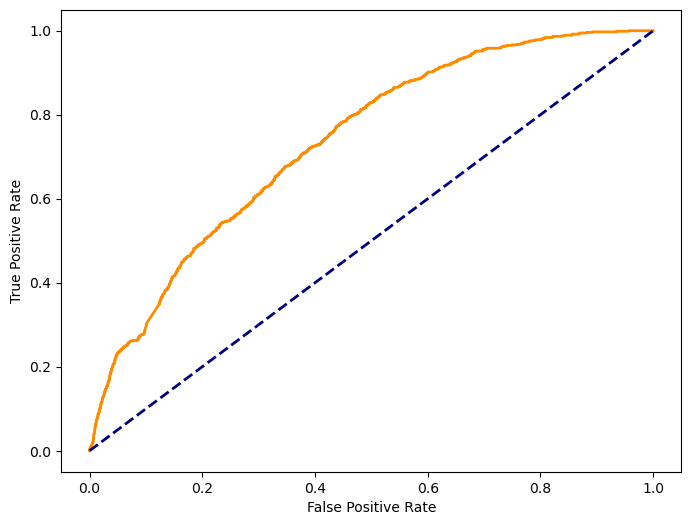

In [33]:
# Plot ROC Curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, X_test.proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()